In [18]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Tomiw\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Dataset shape: (10000, 7)


,date,product_cat,store_region,units_sold,cpi,unemploym,is_holiday
0,2023-04-23,Energy Drink,South,518,253.79,5.55,0
1,2021-07-12,Water Bottle,Central,263,299.68,6.55,1
2,2021-02-22,Apparel,West,675,285.06,4.10,1
3,2023-12-02,Protein Powder,East,277,258.10,6.81,1
4,2022-06-22,Water Bottle,West,915,263.74,4.63,0


Missing values:
 date            0
product_cat     0
store_region    0
units_sold      0
cpi             0
unemploym       0
is_holiday      0
dtype: int64

Model Performance Metrics:
RMSE: 192.55
MAE: 157.08
R² Score: 0.45


<Figure size 1200x600 with 0 Axes>

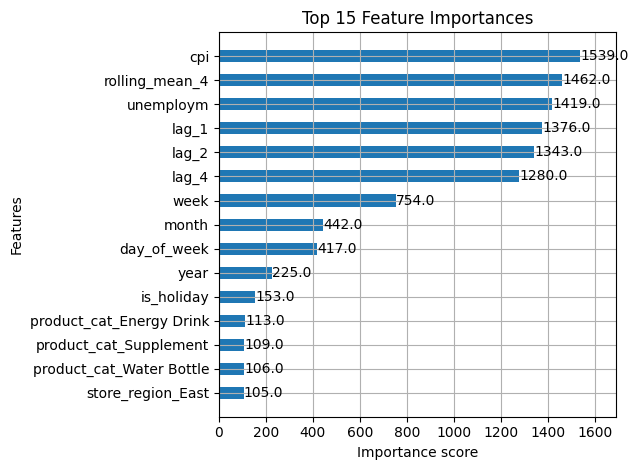

Model saved to xgb_model.pkl


In [19]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor, plot_importance

import joblib
import warnings
warnings.filterwarnings('ignore')


data_path = r"C:\Users\Tomiw\Downloads\healthypact data.csv"
df = pd.read_csv(data_path, parse_dates=['date'])

print("Dataset shape:", df.shape)
display(df.head())


print("Missing values:\n", df.isnull().sum())


df.fillna(method='ffill', inplace=True)


df['product_cat'] = df['product_cat'].astype('category')
df['store_region'] = df['store_region'].astype('category')


df.sort_values(by='date', inplace=True)


df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week
df['day_of_week'] = df['date'].dt.dayofweek
df['year'] = df['date'].dt.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


df['lag_1'] = df['units_sold'].shift(1)
df['lag_2'] = df['units_sold'].shift(2)
df['lag_4'] = df['units_sold'].shift(4)
df['rolling_mean_4'] = df['units_sold'].rolling(window=4).mean()


df.dropna(inplace=True)


df = pd.get_dummies(df, columns=['product_cat', 'store_region'], drop_first=True)


target = 'units_sold'
features = [col for col in df.columns if col not in ['date', 'units_sold']]

X = df[features]
y = df[target]


split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


plt.figure(figsize=(12, 6))
plot_importance(model, max_num_features=15, height=0.5)
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

joblib.dump(model, 'xgb_model.pkl')
print("Model saved to xgb_model.pkl")
